# Analyzing IMDB Data in Keras

In [56]:
# Imports
import numpy as np
#import keras
#import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

## 1. Loading the data
This dataset comes preloaded with Keras, so one simple command will get us training and testing data. There is a parameter for how many words we want to look at. We've set it at 1000, but feel free to experiment.

In [57]:
# Loading the data (it's preloaded in Keras)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

print(x_train.shape)
print(x_test.shape)
word_to_int = imdb.get_word_index()
int_to_word = {i:w for w,i in word_to_int.items()}

(25000,)
(25000,)


In [58]:
def int_word_review(review):
    '''Takes a list of ints as a review and converts it to a worded review'''
    worded_review = ''
    for i in review:
        worded_review += int_to_word[i] + ' '
    return worded_review

## Loading the Word to Int Dictionary from Keras
This reveals a problem with the review data set. When converting the ints to words, the reviews turn out to be garbage...  No wonder I was having trouble below.

In [76]:
print('Review # 15:')
print(int_word_review(x_total[15]))
print('Review # 45:')
print(int_word_review(x_total[45]))

Review # 15:
the is rate hope br my out double this is again country known desperation memories is and and anyway standard planet poem late and to performance not his there's is carrey and just being film jerry in jerry baby and to murders this is and to have into one as fall issues but is on was had can't is dark some br of needed based just table and and of little with barely may and to country presentation don't plot and he 12 in could is opportunity lie wood are is late helps ii wanted not nothing from lost and i'm and jenny as with keep but and and that effects just is remember b was off use of and merely and this of ultimate old 
Review # 45:
the this as aids 2000 as and more he clever and to more he and and expected are clever and of and to clever symbolism one is and opinion decision and and it is clever symbolism is and aids and film is method are and and and is and of energy br about ways and and and were strength most of and and to much and locations and is prince conspiracy

### 1. A. Combine test and training data so we can filter out noise
Use log polarization metric from Trask's Sentiment NN

In [60]:
from collections import Counter

positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

x_total = np.concatenate((x_train,x_test))
y_total = np.concatenate((y_train,y_test))
for idx, review in np.ndenumerate(x_total):
    for word in review:
        if y_total[idx[0]] == 0:
            positive_counts[word] +=1
            total_counts[word] +=1
        elif y_total[idx[0]] == 1:
            negative_counts[word] +=1
            total_counts[word] +=1

# Build Ratios
min_count = 50
pos_neg_ratios = Counter()

for word, count in list(total_counts.most_common()):
    if count > min_count:
        ratio = positive_counts[word] / float(negative_counts[word]+1)
        if ratio > 1:
            pos_neg_ratios[word] = np.log(ratio)
        else:
            pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

print(len(pos_neg_ratios))

4998


### 1. B. Distribution of Ratios
Now, examine the distribution of ratios

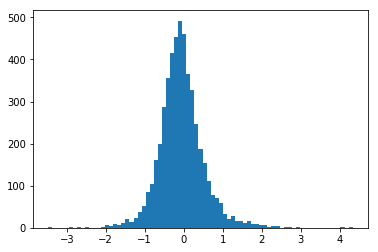

In [61]:
plt.hist(list(pos_neg_ratios.values()), bins=75)
plt.show()

Let's cutoff the words with an absolute value of <= 1 STD (STD = 0.47)

In [62]:
polarity_cutoff = np.std(list(pos_neg_ratios.values())) * 0.01
print('Polarity Cutoff = ', polarity_cutoff)
max_review = 0
max_new = 0
print('Sample Review before: ',x_total[150])
print('Sample Review before: ',int_word_review(x_total[150]))
for idx, review in np.ndenumerate(x_total):
    max_review = max(max_review,len(review))
    new_review = []
    for word in review:
        if np.abs(pos_neg_ratios[word]) > polarity_cutoff:
            new_review.append(word)
    x_total[idx] = new_review
    max_new = max(max_new,len(new_review))
print('Old maximum review length =', max_review)
print('New maximum review length =', max_new)
print('Sample Review after: ',x_total[150])
print('Sample Review after: ',int_word_review(x_total[150]))

Polarity Cutoff =  0.00575069917747
Sample Review before:  [1, 5, 14, 9, 6, 55, 1193, 22, 13, 203, 30, 355, 21, 14, 9, 4, 236, 22, 121, 13, 1192, 2967, 3622, 35, 779, 284, 37, 2, 4, 217, 5, 2132, 6, 749, 10, 10, 2636, 4252, 5, 2931, 4517, 26, 82, 321, 36, 26, 2, 5, 4960, 2, 1786, 8, 358, 4, 704, 117, 122, 36, 124, 51, 62, 593, 375, 10, 10, 4, 1381, 5, 732, 26, 821, 5, 1249, 14, 16, 159, 4, 504, 7, 3728, 4913, 10, 10, 51, 9, 91, 1193, 44, 14, 22, 9, 4, 192, 15, 1370, 40, 14, 131, 1778, 11, 938, 704, 3834, 131, 2, 543, 84, 12, 9, 220, 6, 1117, 5, 6, 320, 237, 4, 3286, 325, 10, 10, 25, 80, 358, 14, 22, 12, 16, 814, 11, 4, 3968, 2, 7, 1226, 2, 63, 131, 1778, 43, 92, 1278, 501, 15, 8, 2, 2, 15, 1609, 131, 47, 24, 77, 2, 237, 2, 2, 158, 158]
Sample Review before:  the to as it is time failed you was action at enjoy not as it of performance you know was sick obsession butt so york shows like and of almost to kung is above i i metal surfing to obnoxious ballet he other shot from he and to defi

In [63]:
xmax = 0
for x in x_total:
    xmax = max(xmax,len(x))
print('Maximum length=',xmax)
num_words = xmax

Maximum length= 2467


### Split it up again

In [64]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size = 0.5, random_state=42)

## 2. Examining the data
Notice that the data has been already pre-processed, where all the words have numbers, and the reviews come in as a vector with the words that the review contains. For example, if the word 'the' is the first one in our dictionary, and a review contains the word 'the', then there is a 1 in the corresponding vector.

The output comes as a vector of 1's and 0's, where 1 is a positive sentiment for the review, and 0 is negative.

In [65]:
print(x_train[0])
print(y_train[0])

[1, 308, 2, 16, 321, 17, 488, 11, 4, 20, 34, 4, 172, 403, 13, 92, 6, 128, 1146, 100, 28, 77, 224, 4, 20, 16, 163, 246, 1301, 488, 9, 6, 55, 406, 2344, 48, 68, 9, 2, 2, 9, 897, 11, 41, 217, 17, 6, 2422, 17, 59, 271, 39, 2793, 8, 2607, 988, 1487, 5, 670, 2, 26, 87, 17, 1486, 2, 257, 2, 23, 2, 4, 2, 7, 4, 2344, 23, 703, 257, 7, 4, 696, 177, 9, 389, 262, 4, 922, 255, 13, 81, 24, 124, 41, 268, 403, 37, 299, 2, 452, 31, 7, 4, 2, 102, 13, 28, 110, 11, 153, 13, 100, 106, 14, 20, 4193, 7, 211]
1


## 3. One-hot encoding the output
Here, we'll turn the input vectors into (0,1)-vectors. For example, if the pre-processed vector contains the number 14, then in the processed vector, the 14th entry will be 1.

In [66]:
x_train[0]

[1,
 308,
 2,
 16,
 321,
 17,
 488,
 11,
 4,
 20,
 34,
 4,
 172,
 403,
 13,
 92,
 6,
 128,
 1146,
 100,
 28,
 77,
 224,
 4,
 20,
 16,
 163,
 246,
 1301,
 488,
 9,
 6,
 55,
 406,
 2344,
 48,
 68,
 9,
 2,
 2,
 9,
 897,
 11,
 41,
 217,
 17,
 6,
 2422,
 17,
 59,
 271,
 39,
 2793,
 8,
 2607,
 988,
 1487,
 5,
 670,
 2,
 26,
 87,
 17,
 1486,
 2,
 257,
 2,
 23,
 2,
 4,
 2,
 7,
 4,
 2344,
 23,
 703,
 257,
 7,
 4,
 696,
 177,
 9,
 389,
 262,
 4,
 922,
 255,
 13,
 81,
 24,
 124,
 41,
 268,
 403,
 37,
 299,
 2,
 452,
 31,
 7,
 4,
 2,
 102,
 13,
 28,
 110,
 11,
 153,
 13,
 100,
 106,
 14,
 20,
 4193,
 7,
 211]

In [67]:
# One-hot encoding the output into vector mode, each of length 1000
tokenizer = Tokenizer(num_words=num_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print(x_train[0])

[ 0.  1.  1. ...,  0.  0.  0.]


And we'll also one-hot encode the output.

In [68]:
# One-hot encoding the output
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(25000, 2467) (25000, 2)
(25000, 2467) (25000, 2)


## 4. Building the  model architecture
Build a model here using sequential. Feel free to experiment with different layers and sizes! Also, experiment adding dropout to reduce overfitting.

In [69]:
print('Max Number of Words:', num_words)
print('Training Data shape:',x_train.shape)
print('Number of classes:',num_classes)

Max Number of Words: 2467
Training Data shape: (25000, 2467)
Number of classes: 2


In [79]:
# TODO: Build the model architecture
# Building the model
model = Sequential()
model.add(Dense(max(num_words//2,100), activation='relu', input_dim=num_words))
model.add(Dropout(.3))
#model.add(Dense(80, activation='relu'))
#model.add(Dropout(.2))
#model.add(Dense(num_words//2, activation='relu'))
#model.add(Dropout(.2))
model.add(Dense(num_classes, activation='softmax'))

# TODO: Compile the model using a loss function and an optimizer.
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1233)              3043044   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1233)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2468      
Total params: 3,045,512
Trainable params: 3,045,512
Non-trainable params: 0
_________________________________________________________________


## 5. Training the model
Run the model here. Experiment with different batch_size, and number of epochs!

In [80]:
# TODO: Run the model. Feel free to experiment with different batch sizes and number of epochs.

model.fit(x_train, y_train, epochs=15, batch_size=48, verbose=1)

Epoch 1/15
25000/25000 [==============================] - 4s - loss: 0.3608 - acc: 0.8502     
Epoch 2/15
25000/25000 [==============================] - 3s - loss: 0.2586 - acc: 0.9013     
Epoch 3/15
25000/25000 [==============================] - 3s - loss: 0.2207 - acc: 0.9255     
Epoch 4/15
25000/25000 [==============================] - 3s - loss: 0.1755 - acc: 0.9456     
Epoch 5/15
25000/25000 [==============================] - 3s - loss: 0.1402 - acc: 0.9628     
Epoch 6/15
25000/25000 [==============================] - 3s - loss: 0.1101 - acc: 0.9727     
Epoch 7/15
25000/25000 [==============================] - 3s - loss: 0.0902 - acc: 0.9806     
Epoch 8/15
25000/25000 [==============================] - 3s - loss: 0.0710 - acc: 0.9855     
Epoch 9/15
25000/25000 [==============================] - 3s - loss: 0.0596 - acc: 0.9884     
Epoch 10/15
25000/25000 [==============================] - 3s - loss: 0.0493 - acc: 0.9908     
Epoch 11/15
25000/25000 [========================

## 6. Evaluating the model
This will give you the accuracy of the model, as evaluated on the testing set. Can you get something over 85%?

In [78]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: ", score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", score[1])

Train Accuracy:  0.99848
Test Accuracy:  0.86868


In [73]:
len(x_train[1])

2467

## Solution

In [74]:
# Building the model architecture with one layer of length 100
smodel = Sequential()
#smodel.add(Dense(512, activation='relu', input_dim=num_words))
smodel.add(Dense(100, activation='relu', input_dim=num_words))
smodel.add(Dropout(0.3))
smodel.add(Dense(num_classes, activation='softmax'))
smodel.summary()

# Compiling the model using categorical_crossentropy loss, and rmsprop optimizer.
smodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Running and evaluating the model
hist = smodel.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test), 
          verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               246800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 247,002
Trainable params: 247,002
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
5s - loss: 0.3451 - acc: 0.8545 - val_loss: 0.2965 - val_acc: 0.8786
Epoch 2/10
5s - loss: 0.2696 - acc: 0.8936 - val_loss: 0.3073 - val_acc: 0.8816
Epoch 3/10
4s - loss: 0.2527 - acc: 0.9039 - val_loss: 0.3196 - val_acc: 0.8806
Epoch 4/10
5s - loss: 0.2405 - acc: 0.9128 - val_loss: 0.3287 - val_acc: 0.8798
Epoch 5/10
5s - loss: 0.2296 -

In [75]:
sscore = smodel.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: ", sscore[1])
sscore = smodel.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", sscore[1])

Train Accuracy:  0.955
Test Accuracy:  0.87468
